# DEMETER Satellite - IAP Sensor Data Processing

## Calculating correction terms for $\mathrm{H}^{+}$ ion data

### Initialization

Loading in necessary libraries:

In [96]:
pr = reload(pr)

In [1]:
import fun.read_data as rd
import fun.process_datapoints as pr
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
from math import exp
from importlib import reload

%matplotlib inline

In [ ]:
def calc_dist(x, y, a, b):

    """
    Calculates the distance of points x,y from the line defined by
    the equation: y = ax + b
    """

    from math import sqrt

    return np.abs(a * x - y + b) / sqrt(a * a + 1)

Loading data files.

In [2]:
# required field: CNES Julian day, H+ ion densities, magnetic latitude and longitude
req = ['cnesjd', 'h', 'mlat', 'mlon', 'alt']

# Loading only day data
day, _ = rd.read_data("paths/full", required=req)

In [3]:
# filtering out low ion densities and restricitng mag. lat. values
day = day[(day['h']  < 1.4e4) & (day['h'] > 100) & (day['mlat'] > -60) & (day['mlat'] < 60)]

Binning data for mag.lat. values and CNES Jd. values.

In [10]:
# creating bins, from max. to min. 1 degree bin width
mlat_median, mlat_bins, _ = stats.binned_statistic(day['mlat'], day['h'], statistic='median', bins=120)
mlat_half_width = (mlat_bins[1] - mlat_bins[0]) / 2.0

In [10]:
# creating bins, from max. to min. 20 day bin width
cnesjd_median, cnesjd_bins, _ = stats.binned_statistic(day['cnesjd'], day['h'], statistic='median', bins=1e3)
cnesjd_half_width = (cnesjd_bins[1] - cnesjd_bins[0]) / 2.0

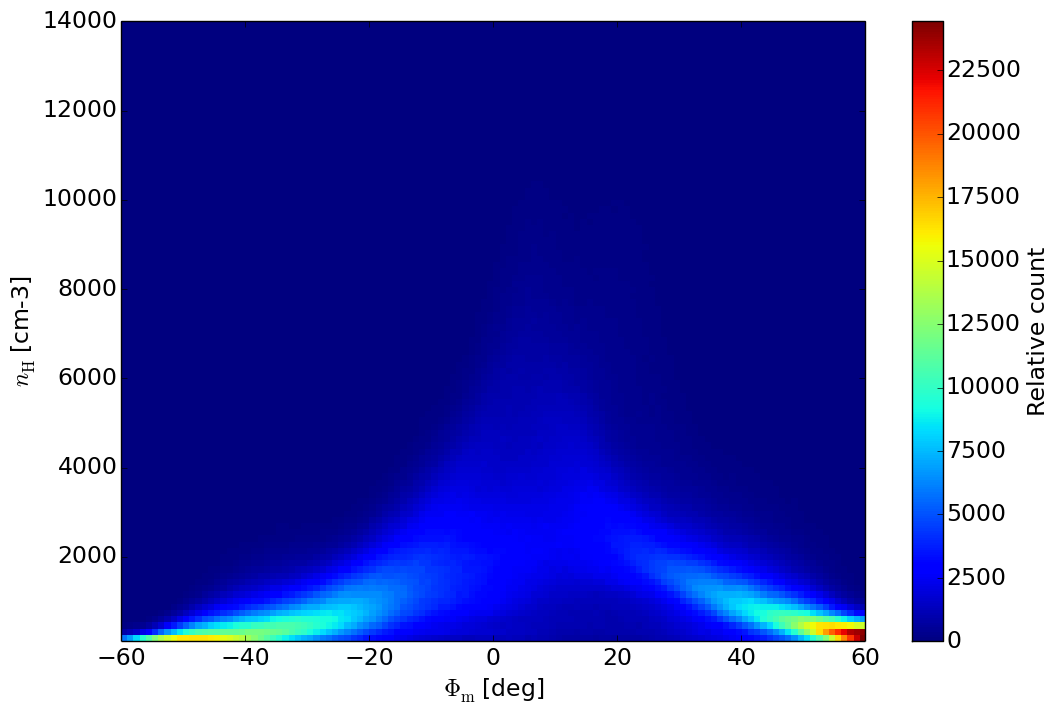

In [4]:
# plotting 2d histogram and H+ ion median values in bins
plt.figure(figsize=(12,8), dpi=100)

plt.xlabel(r'$\Phi_{\mathrm{m}}$ [deg]', size=17)
plt.ylabel(r'$n_{\mathrm{H}}$ [cm-3]', size=17)
plt.tick_params(labelsize=17)

counts, _, yedges, _ = plt.hist2d(day['mlat'], day['h'], bins=[120, 100], normed=False)

h_low = yedges[0]
h_high = yedges[-1]

cbar = plt.colorbar()
cbar.set_label('Relative count', size=17)
cbar.ax.tick_params(labelsize=17)

#plt.plot(mlat_bins[0:-1] + mlat_half_width, mlat_median, 'k-', linewidth=2.5);

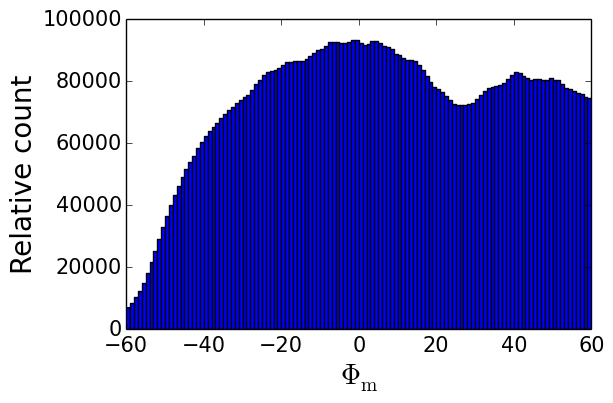

In [5]:
plt.figure(dpi=100)
n, _, _ = plt.hist(day['mlat'], bins=120);
plt.xlabel(r'$\Phi_{\mathrm{m}}$', size=20)
plt.ylabel('Relative count', size=20)
plt.tick_params(labelsize=15)

In [6]:
counts = np.rot90(counts)

In [7]:
counts_corrected = np.multiply(counts, np.tile(np.reciprocal(n), (100, 1)))

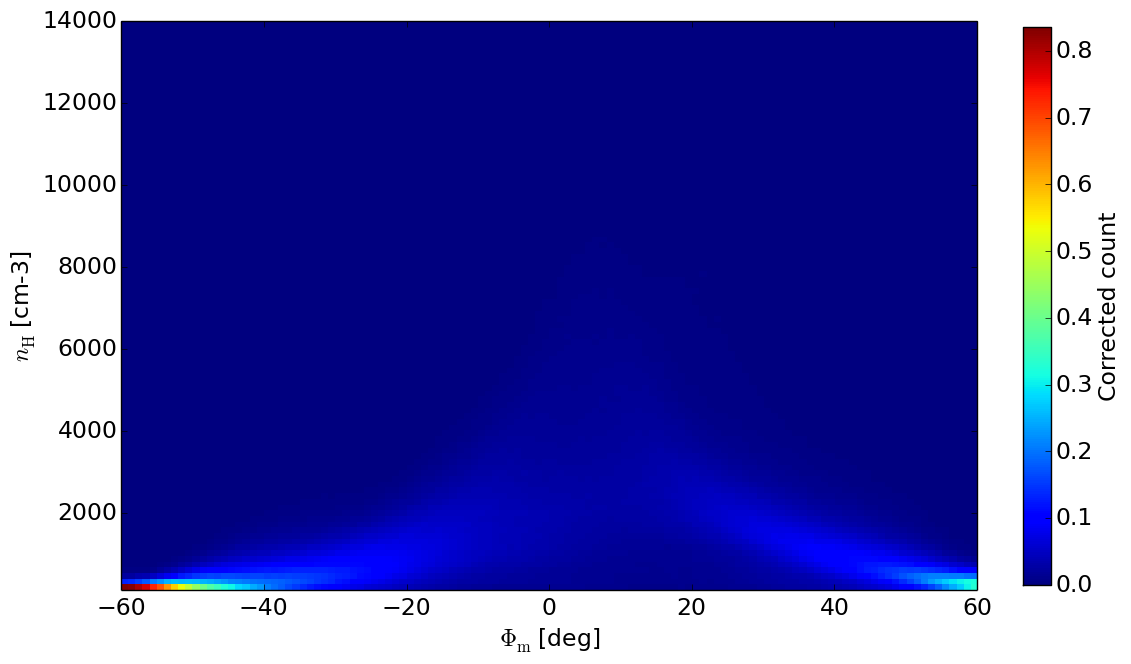

In [27]:
plt.figure(figsize=(12,8), dpi=100)

plt.xlabel(r'$\Phi_{\mathrm{m}}$ [deg]', size=17)
plt.ylabel(r'$n_{\mathrm{H}}$ [cm-3]', size=17)
plt.tick_params(labelsize=17)

plt.imshow(counts_corrected, extent=(mlat_bins[0], mlat_bins[-1], h_low, h_high),
           aspect=5.75e-3, interpolation='nearest')

cbar = plt.colorbar(fraction=0.03)
cbar.set_label('Corrected count', size=17)
cbar.ax.tick_params(labelsize=17)

#plt.plot(mlat_bins[0:-1] + mlat_half_width, mlat_median, 'k-', linewidth=2.5);

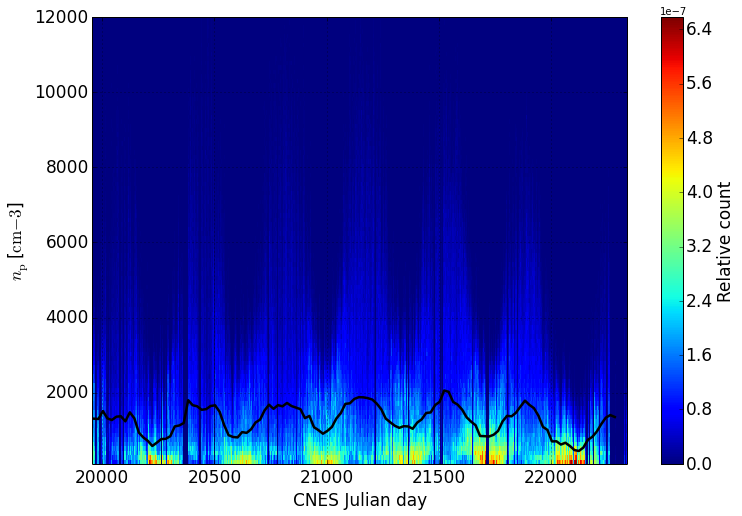

In [89]:
plt.figure(figsize=(12,8))
pr.hist_data(day, ['cnesjd', 'h'], axis=[day['cnesjd'].min(), day['cnesjd'].max(), 100, 1.2e4], bin_num=[1e3, 100])
#pr.hist_data(day, ['cnesjd', 'h'], axis=[day['cnesjd'].min(), day['cnesjd'].max(), 100, 1.5e4], bin_num=10)
plt.plot(cnesjd_points, cnesjd_median, 'k-', linewidth=2.5);

In [91]:
z, V = np.polyfit(mlat_points, np.log10(mlat_median), 5, cov=True)
p = np.poly1d(z)
mlat = np.arange(mlat_points.min(), mlat_points.max(), 1)

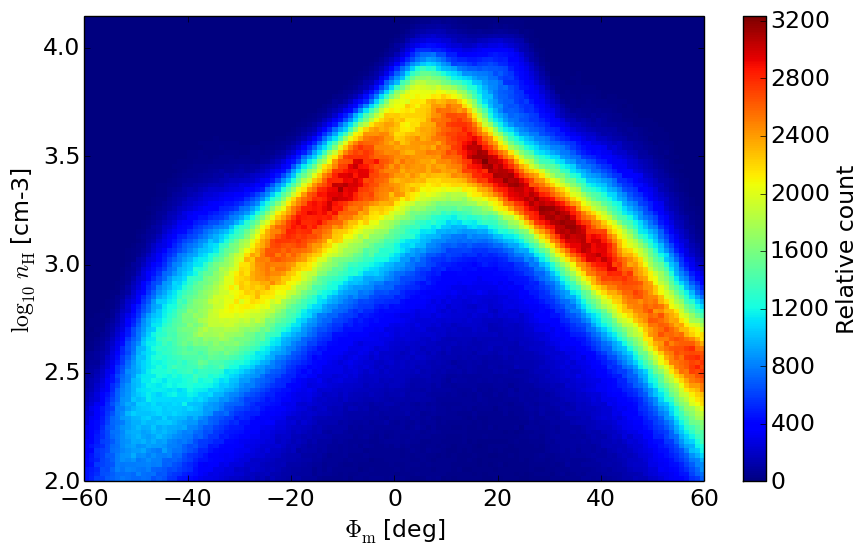

In [31]:
# plotting 2d histogram and H+ ion median values in bins
plt.figure(figsize=(10,6), dpi=100)

plt.xlabel(r'$\Phi_{\mathrm{m}}$ [deg]', size=17)
plt.ylabel(r'$\mathrm{log}_{10}$ $n_{\mathrm{H}}$ [cm-3]', size=17)
plt.tick_params(labelsize=17)

plt.hist2d(day['mlat'], np.log10(day['h']), bins=[120, 100], normed=False)

#h_low = yedges[0]
#h_high = yedges[-1]

cbar = plt.colorbar()
cbar.set_label('Relative count', size=17)
cbar.ax.tick_params(labelsize=17)

#plt.plot(mlat_bins[0:-1] + mlat_half_width, mlat_median, 'k-', linewidth=2.5);

In [23]:
print(z)
print(V.diagonal())

[ -3.12342594e-11   1.31713415e-09   1.72301426e-07  -6.73557239e-06
  -5.69447393e-04   1.19920138e-02   3.42644664e+00]
[  3.90792775e-24   3.97833012e-21   7.97048111e-17   5.15375689e-14
   1.16069765e-10   3.39022741e-08   8.87560679e-06]


In [94]:
h_corr = np.power(10, p(day['mlat']))

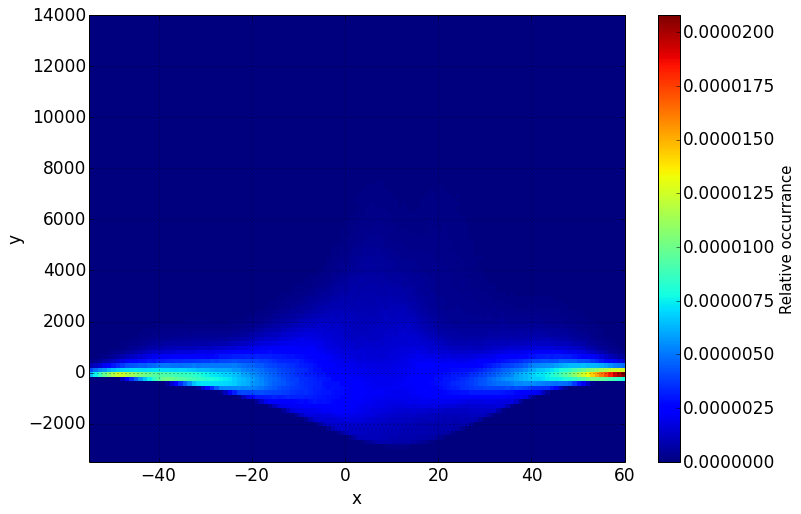

In [97]:
plt.figure(figsize=(12,8))
pr.hist_raw(day['mlat'], day['h'] - h_corr, axis=[-55, 60, -3.5e3, 1.4e4], bin_num=[120, 100])
#plt.plot(mlat_points, mlat_median, 'k-', linewidth=2.5)

In [98]:
cnesjd_median, _, _ = stats.binned_statistic(day['cnesjd'], day['h'] - h_corr,
                                                       statistic='median', bins=cnesjd_bins)

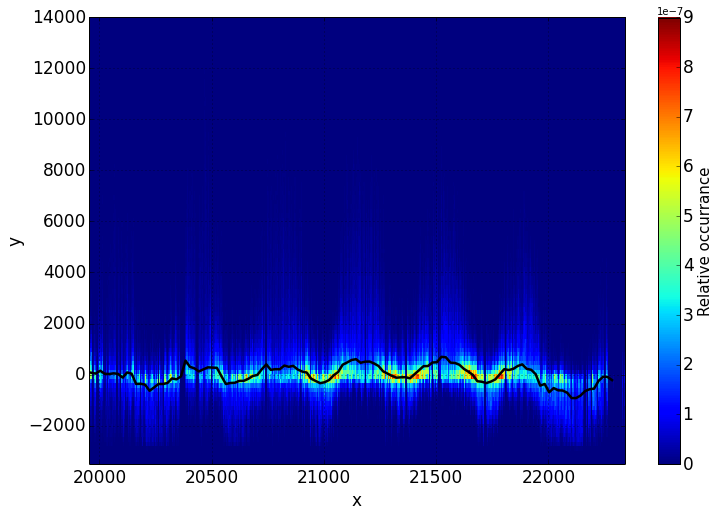

In [101]:
plt.figure(figsize=(12,8))
pr.hist_raw(day['cnesjd'], day['h'] - h_corr,
            axis=[day['cnesjd'].min(), day['cnesjd'].max(), -3.5e3, 1.4e4], bin_num=[1e3, 100])
plt.plot(cnesjd_points, cnesjd_median, 'k-', linewidth=2.5);

In [102]:
h_corr += np.interp(day['cnesjd'], cnesjd_points, cnesjd_median)

/usr/lib/python3/dist-packages/numpy/lib/function_base.py:365: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


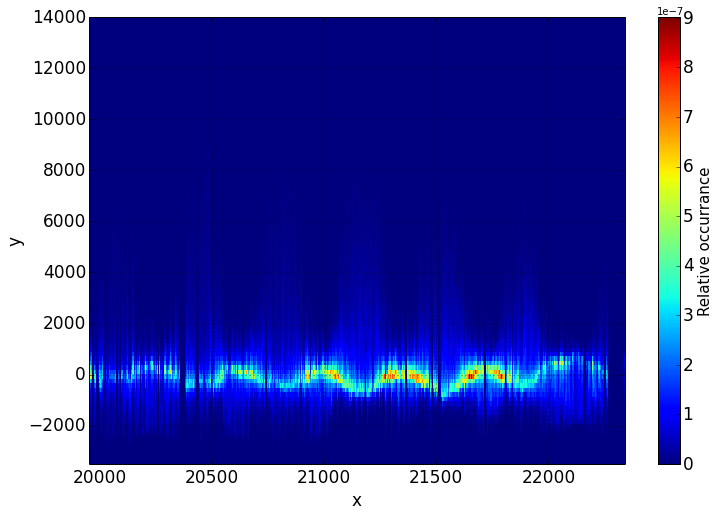

In [103]:
plt.figure(figsize=(12,8))
pr.hist_raw(day['cnesjd'], day['h'] - h_corr,
            axis=[day['cnesjd'].min(), day['cnesjd'].max(), -3.5e3, 1.4e4], bin_num=[1e3, 100])
#plt.plot(cnesjd_points, cnesjd_median_mlat_corr, 'k-', linewidth=2.5)

/usr/lib/python3/dist-packages/numpy/lib/function_base.py:365: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


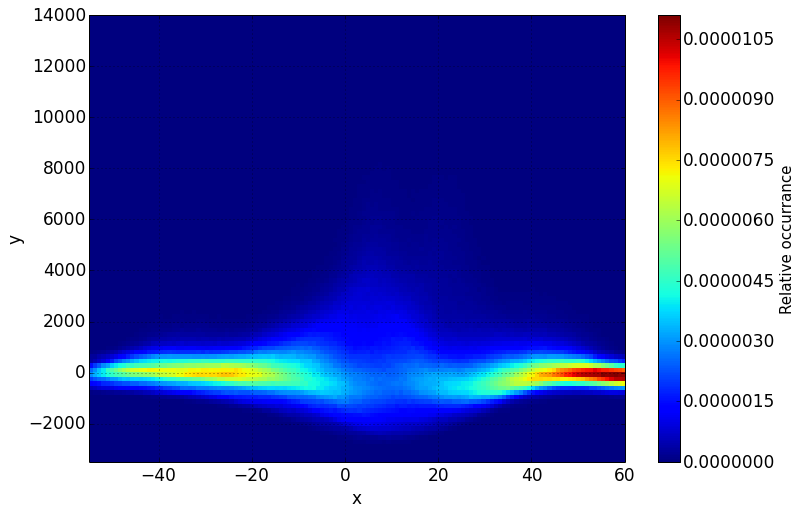

In [104]:
plt.figure(figsize=(12,8))
pr.hist_raw(day['mlat'], day['h'] - h_corr, axis=[-55, 60, -3.5e3, 1.4e4], bin_num=[130, 100])
#plt.plot(mlat_points, mlat_median, 'k-', linewidth=2.5)

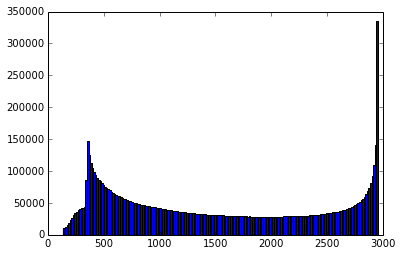

In [112]:
plt.hist(np.power(10, p(day['mlat'])), bins=200);

In [106]:
np.sum(np.isnan(h_corr))

5174

In [107]:
h_median, mlon_edge, mlat_edge, _ = stats.binned_statistic_2d(day['mlon'], day['mlat'], day['h'],
                                                              statistic='median', bins=[90, 30])

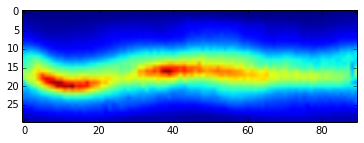

In [108]:
plt.imshow(h_median.T, interpolation=None);

In [109]:
h_median, mlon_edge, mlat_edge, _ = stats.binned_statistic_2d(day['mlon'], day['mlat'], day['h'] - h_corr,
                                                              statistic='median', bins=[90, 30])

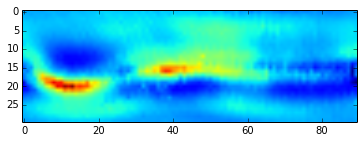

In [110]:
plt.imshow(h_median.T, interpolation=None);